In [ ]:
##################################
### GENERALISED ADDITIVE MODEL ###
##################################

# For running separately when RFR is taking a long time # 

In [1]:
#Read in the packages to use
import numpy as np
import pandas as pd
import math
import datetime
import os
import pathlib
import matplotlib.pyplot as plt
import earthpy as et
import pandas as pd
import pickle
#for displaying the cities on map
#import cartopy
#import cartopy.crs as ccrs

#models
from pygam import LinearGAM, s, f     #import GAM for regression problems
#from sklearn.linear_model import LinearRegression 
#import statsmodels.api as sm                                          #stats models to get linear reg p-values
#from statsmodels.tools.eval_measures import rmse                      #calc rmse from stats models
#import itertools                                                      #for calculating possible combinations of variables
#from sklearn.preprocessing import PolynomialFeatures                  #for polynomial regression
#from sklearn.pipeline import make_pipeline                            #pipeline to create polynomial regression

#use grid search to find hyperparameters (pg 73 Geron) RFR
from sklearn.model_selection import GridSearchCV                      #for cross validation
from sklearn.model_selection import cross_val_score                   #for cross validation
from sklearn.model_selection import KFold                            
from sklearn.model_selection import GridSearchCV 
from sklearn.preprocessing import StandardScaler                      #for normalising the data
from sklearn.metrics import r2_score                                  #metrics for assessing model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#for plotting
from matplotlib import ticker 
from matplotlib.ticker import MaxNLocator                             #to keep whole numbers on the x-axis
from matplotlib.lines import Line2D                                   #for manual legend creation
from sklearn.inspection import PartialDependenceDisplay               #for the partial dependence plots
#Read in the data

#read in the city info table
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT'))
CITY_COUNTRY_lat_lon = pd.read_excel('CITY_COUNTRY_lat_lon.xlsx', index_col=None)

#read the table with all variables in as pickle
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','UHI_Project_Pickle_Files','All_cities'))   
with open('aqua_all_monthly_data_df2.pkl', 'rb') as f:
    all_monthly_data_df = pickle.load(f)

# remove years after 2015 until have sorted the area data for 2016-2020
all_monthly_data_df = all_monthly_data_df[all_monthly_data_df.year <= 2015]

#remove nans
#all_monthly_data_df = all_monthly_data_df[(~np.isnan(all_monthly_data_df['rur_mean_evi'])
#                    ) & (~np.isnan(all_monthly_data_df['urb_mean_evi'])
#                    ) & (~np.isnan(all_monthly_data_df['a0']))].copy()

# URBAN - RURAL differences
# add evi difference variable
all_monthly_data_df['evi_diff'] = all_monthly_data_df['urb_mean_evi'] - all_monthly_data_df['rur_mean_evi'] 
# add in climate difference variables
all_monthly_data_df['evap_fract_diff'] = all_monthly_data_df['urban_evap_fract'] - all_monthly_data_df['rural_evap_fract'] 
all_monthly_data_df['rh_diff'] = all_monthly_data_df['urban_rh'] - all_monthly_data_df['rural_rh']
all_monthly_data_df['tp_diff'] = all_monthly_data_df['urban_tp'] - all_monthly_data_df['rural_tp']
all_monthly_data_df['ssr_diff'] = all_monthly_data_df['urban_ssr'] - all_monthly_data_df['rural_ssr']

# add in the log_area_x_ef variable 
# Define the ef function
def logarea_ef(x_ef, threshold_ef, m, c):
    x, ef = x_ef
    y = m*(x * (ef - threshold_ef)) + c
    return y
# set values of the area function parameters
threshold_ef = 0.498 
m = 6.622
c = 2.797
x_ef = np.log10(all_monthly_data_df.Area.values.astype(float)), all_monthly_data_df.annual_rural_ef

all_monthly_data_df['log_area_x_rur_ef'] = logarea_ef(x_ef, threshold_ef, m, c)

#split into training and test data
#take the test data as 4 cities, the training as 14?
#or test as 3 cities, training as 15

#define the test cities to remove
test_cities = ['Sikasso', 'Anapolis', 'Campo_Grande', 'Bobo_Dioulasso', 'Diwaniyah', 'Al_Obeid', 'Akola', 'Potiskum','Cascavel']

#define the overpass time 
overpass_time = '13:30'

#define the predictor and target values for training and test data
#what predictors to use?
predictor_variables_all = ['evap_fract_diff', 'rural_evap_fract', 'rh_diff', 'rural_rh','tp_diff' ,'rural_tp', 
                           'rural_t2m','ssr_diff','rural_ssr','rur_mean_evi', 'evi_diff', 'log_area_x_rur_ef',
                           'Eccentricity']

# just ssr and ef
predictor_variables_1 = ['evap_fract_diff', 'rural_evap_fract','ssr_diff','rural_ssr','rur_mean_evi', 'evi_diff', 
                         'log_area_x_rur_ef', 'Eccentricity']

# rh instead of ef
predictor_variables_2 = ['rh_diff', 'rural_rh','ssr_diff','rural_ssr','rur_mean_evi', 'evi_diff', 
                         'log_area_x_rur_ef', 'Eccentricity']


predictor_variables = predictor_variables_1

target_variable = 'a0'
#target_variable = 'method_2_SUHI'
#target_variable = 'quantile_a0'

#clean the data - first remove columns which are not the target or predictor variables, then remove nans
variables = predictor_variables.copy()
variables.append(target_variable)
variables.append('City')
variables.append('Overpass')
all_monthly_data_df2 = all_monthly_data_df[variables]
all_monthly_data_df2 = all_monthly_data_df2.dropna()

#create training and test datasets
training_data = all_monthly_data_df2[((~all_monthly_data_df2['City'].isin(test_cities)) 
                                    & (all_monthly_data_df2['Overpass'] == overpass_time))].copy()
test_data = all_monthly_data_df2[((all_monthly_data_df2['City'].isin(test_cities))
                                  & (all_monthly_data_df2['Overpass'] == overpass_time))].copy()

print('Train_percent', 100* len(training_data)/len(all_monthly_data_df2[all_monthly_data_df2['Overpass'] == overpass_time]))
print('Test_percent', 100* len(test_data)/len(all_monthly_data_df2[all_monthly_data_df2['Overpass'] == overpass_time]))
print('Total Datapoints',len(all_monthly_data_df2[all_monthly_data_df2['Overpass'] == overpass_time]))

#split the data into training and test

X_train = training_data[predictor_variables]  #predictors
y_train = training_data[target_variable]      #target

X_test = test_data[predictor_variables]       #predictors
y_test = test_data[target_variable]           #target

#get the groups
groups_train = training_data.City
groups_test = test_data.City

#create normalised datasets
#the test dataset is normalised using the normalisation parameters from the training data
scaler = StandardScaler()
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns) #fit and transform
X_test_norm = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns) #transform only
y_train_norm = pd.DataFrame(scaler.fit_transform(y_train.values.reshape(-1,1)), columns = [target_variable]) #fit and transform
y_test_norm = pd.DataFrame(scaler.transform(y_test.values.reshape(-1, 1)), columns = [target_variable]) #transform only


Train_percent 78.53674870249456
Test_percent 21.46325129750544
Total Datapoints 5973


In [3]:
# Fit a linear GAM 
gam = LinearGAM().fit(X_train_norm, y_train)


In [16]:
lam = np.array([0.6,10,100]) # hyperparameter values to try
lams = [lam] * 8 # there are 8 splines

gam_reg = gam.gridsearch(X_train_norm, y_train, lam = lams)
#save the model to load in later 
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','UHI_Project_Pickle_Files','All_cities'))  
filename = 'finalised_model_gam_a0.sav'
pickle.dump(gam_reg, open(filename, 'wb'))
gam.summary()

100% (6561 of 6561) |####################| Elapsed Time: 1:13:43 Time:  1:13:43


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     65.0952
Link Function:                     IdentityLink Log Likelihood:                                -11768.7513
Number of Samples:                         4691 AIC:                                            23669.6931
                                                AICc:                                           23671.6112
                                                GCV:                                                4.4933
                                                Scale:                                              4.3812
                                                Pseudo R-Squared:                                   0.7469
Feature Function                  Lam

C:\Users\UEA_Laptop\AppData\Local\Temp\ipykernel_5996\2237015765.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [ ]:
#load model 
#read in the model
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','UHI_Project_Pickle_Files','All_cities'))  
filename = 'finalised_model_gam_a0.sav'
gam_reg = pickle.load(open(filename, 'rb'))

In [6]:
#Performance stats for GAM
y_train_pred = gam.predict(X_train_norm)
y_test_pred = gam.predict(X_test_norm)

#####################################################
###### Performance Metrics for the training set ######
######################################################
#rmse
gam_mse = mean_squared_error(y_train, y_train_pred)
gam_rmse = np.sqrt(gam_mse)
#r-square
gam_r2 = r2_score(y_train, y_train_pred)
#mae
gam_mae = mean_absolute_error(y_train, y_train_pred)
print('Training Metrics--', 'RMSE:', gam_rmse, 'R-square:', gam_r2, 'MAE:', gam_mae)

#################################################
###### Performance Metrics for the test set #####
#################################################
#rmse
test_gam_mse = mean_squared_error(y_test, y_test_pred)
test_gam_rmse = np.sqrt(test_gam_mse)
#r-square
test_gam_r2 = r2_score(y_test, y_test_pred)
#mae
test_gam_mae = mean_absolute_error(y_test, y_test_pred)
print('Test Metrics--', 'RMSE:', test_gam_rmse, 'R-square:', test_gam_r2, 'MAE:', test_gam_mae)


Training Metrics-- RMSE: 2.078548999730211 R-square: 0.7468878932699928 MAE: 1.540243542726449
Test Metrics-- RMSE: 2.1529414975103465 R-square: 0.5832650605341083 MAE: 1.693685173660809


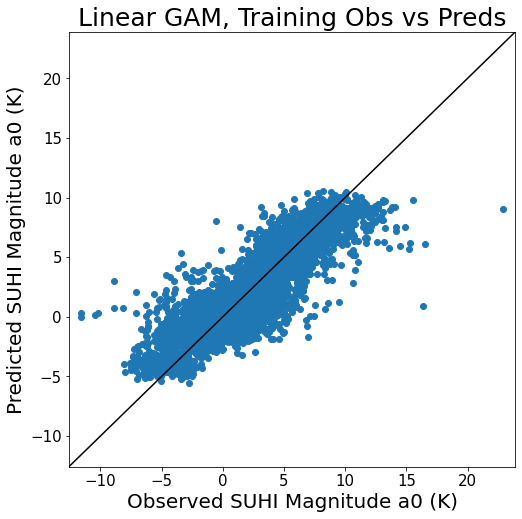

In [7]:
# Plotting 

#plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=25)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
#plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title


fig, axes = plt.subplots(1,1, figsize = (8, 8))

axes.scatter(y_train, y_train_pred)
axes.set(title = 'Linear GAM, Training Obs vs Preds', 
         xlabel = 'Observed SUHI Magnitude a0 (K)', ylabel = 'Predicted SUHI Magnitude a0 (K)')
         #xlabel = 'Observed SUHI Mean (K)', ylabel = 'Predicted SUHI Mean (K)')

axesmin = min(min(y_train), min(y_train_pred)) - 1
axesmax = max(max(y_train), max(y_train_pred)) + 1

axes.set_xlim([axesmin, axesmax])
axes.set_ylim([axesmin, axesmax])

axes.plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

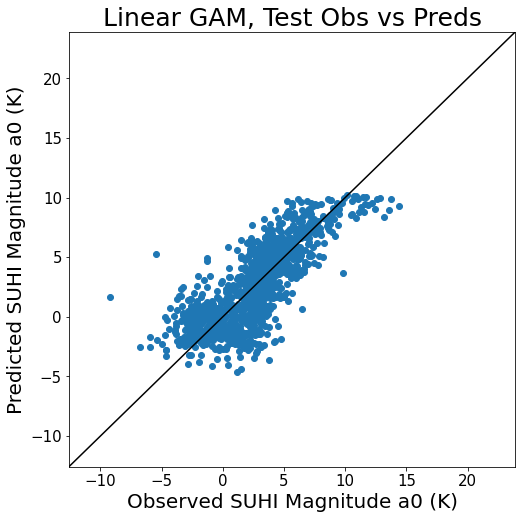

In [8]:
fig, axes = plt.subplots(1,1, figsize = (8, 8))

axes.scatter(y_test, y_test_pred)
axes.set(title = 'Linear GAM, Test Obs vs Preds', 
         xlabel = 'Observed SUHI Magnitude a0 (K)', ylabel = 'Predicted SUHI Magnitude a0 (K)')
         #xlabel = 'Observed SUHI Mean (K)', ylabel = 'Predicted SUHI Mean (K)')

axesmin = min(min(y_train), min(y_train_pred)) - 1
axesmax = max(max(y_train), max(y_train_pred)) + 1

axes.set_xlim([axesmin, axesmax])
axes.set_ylim([axesmin, axesmax])

axes.plot([axesmin, axesmax],[axesmin, axesmax], color = 'k')

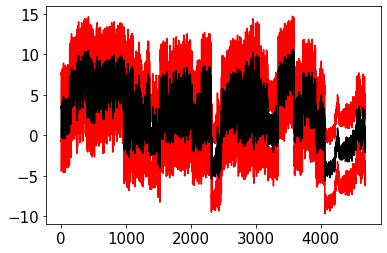

In [11]:
# confidence intervals
predi = gam.prediction_intervals(X_train_norm, width = 0.95)
plt.plot(predi, c = 'r', ls = '-')
plt.plot(y_train_pred, c = 'k')


In [12]:
predi

array([[-4.37318058,  3.87600804],
       [-4.13284825,  4.11173678],
       [-1.75560461,  6.47675304],
       ...,
       [-4.17536014,  4.07343203],
       [-5.19266032,  3.04927446],
       [-5.57765713,  2.66740552]])

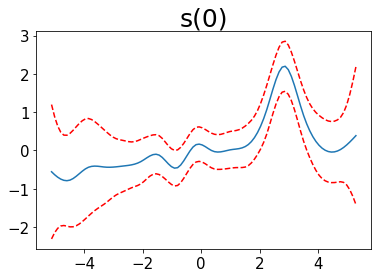

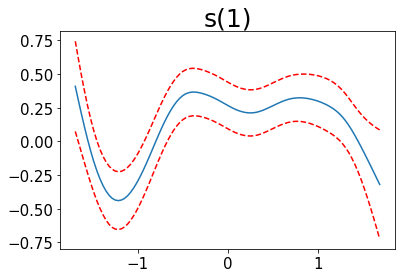

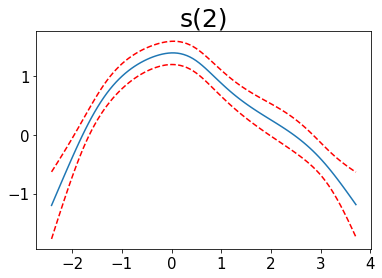

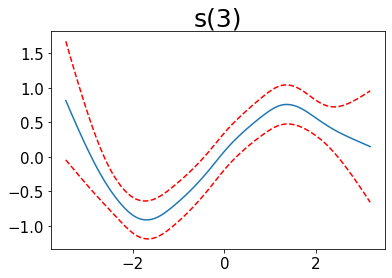

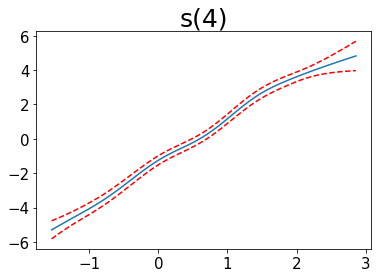

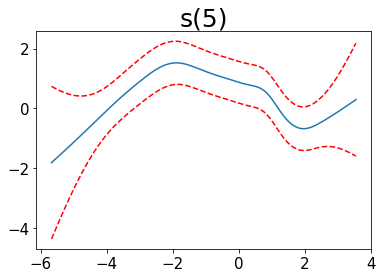

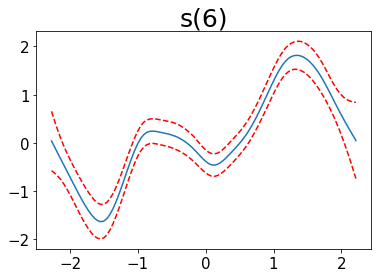

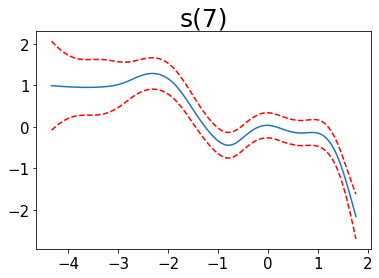

In [21]:
# partial dependence plots of the splines

for i, term in enumerate(gam_reg.terms):
    if term.isintercept:
        continue

    XX = gam_reg.generate_X_grid(term=i)
    pdep, confi = gam_reg.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()